### started making example plot that would be similar to stringer 2019 fig 2D



In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.readout import predict_downstream_reduced_rank_regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [24]:
basepath = "Z:\Data\HMC1\day12"
# basepath = r"Z:\Data\Kenji\ec016.532_540"

reference_region=["CA1"]
target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]
rip_exp_start=0.05
rip_exp_stop=0.2

(
    st,
    cm,
    ripple_epochs,
    ep_epochs,
    ep_df,
    session_epoch,
    nrem_epochs,
    wake_epochs,
) = predict_downstream_reduced_rank_regressor.get_data(
    basepath,
    target_regions,
    reference_region,
    rip_exp_start=rip_exp_start,
    rip_exp_stop=rip_exp_stop,
)

In [25]:
curr_ripples = ripple_epochs[wake_epochs]

st_par = functions.get_participation(
    st[wake_epochs].data,
    curr_ripples.starts,
    curr_ripples.stops,
    par_type="firing_rate",
)

In [140]:
ca1_idx = (
    cm.brainRegion.str.contains("CA1").values
)
target_idx = (
    cm.brainRegion.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC").values
)

print(sum(target_idx))
print(sum(ca1_idx))

213
100


In [141]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(st_par)

X_train, X_test, y_train, y_test = train_test_split(
    X[ca1_idx, :].T,
    X[target_idx, :].T,
    test_size=0.4,
    random_state=42,
    shuffle=False,
)
n_grid=20  # number of grid search parameters to use
max_rank=30
cv=5
grid_search_result = predict_downstream_reduced_rank_regressor.run_grid_search(
    X_train, y_train, n_grid=n_grid, cv=cv, max_rank=max_rank
)


In [142]:
from ripple_heterogeneity.utils import (
    kernel_reduced_rank_ridge_regression,
)
from sklearn.metrics import mean_squared_error

regressor = (
    kernel_reduced_rank_ridge_regression.ReducedRankRegressor()
)
regressor.rank = int(grid_search_result.best_params_["rank"])

regressor.reg = 1

regressor.fit(X_train, y_train)

mse = mean_squared_error(
    y_test, regressor.predict(X_test), multioutput="raw_values"
)


In [143]:
np.argsort(mse)

# np.sort(mse)

array([ 59,  13,  61, 121, 107, 119, 193, 118,  17,  97,  19,   9,  66,
        64,  80,  67,   8, 140, 153,  94,  57, 204, 127,   4,  86, 101,
       123,  69, 180, 194, 199,  44,  75,  42, 189, 116, 145, 132, 208,
       181, 202,  39,  72, 142,  82, 201,  29,  45,  65, 124, 187, 160,
       162, 183, 143,   3, 129, 182,  55, 173, 117, 103,  83,  31, 115,
        48, 188, 179,  37,  92, 178,  96, 149,  79, 169, 177, 175, 185,
        41, 135, 195, 136,  54,  33,  30,  99, 197, 138,  58,  28,  78,
       111, 112,  36, 131, 191, 128,  74, 104, 133,  35, 109, 110,  46,
       108,  47,   5, 171, 196, 106, 200,  93, 207, 186, 174, 122, 126,
       147, 206,  21, 205,  91,  89,  43,  16, 184, 120, 198,  14,  95,
        77, 190,   6,  32, 141, 125,  63, 137,  88,  90, 176,  10,   1,
        51, 203,  38, 105,  34,  87,  49,  68, 155, 102,  85, 192,  56,
        62,  22,  20,  11,  12, 134, 144, 164,  40, 172,   7, 146,  26,
       166, 100,  25,  23, 168,  50, 163,  18,  52,  71,  27, 13

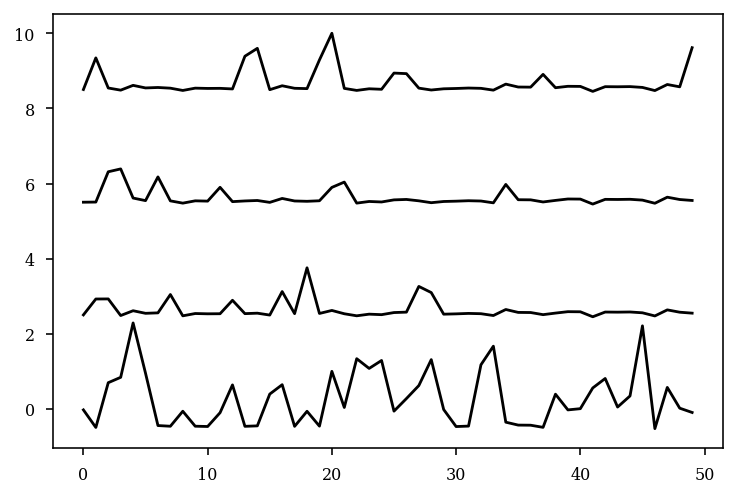

In [144]:
for i in range(4):
    plt.plot(X_test[0:50,i]+i*3,color='k')

In [ ]:
# y_test[0:50,8]
i=1
plt.plot(y_test[0:50,i]+i*3,color='k')

plt.plot(y_pred[0:50,i]+i*3,color='r')


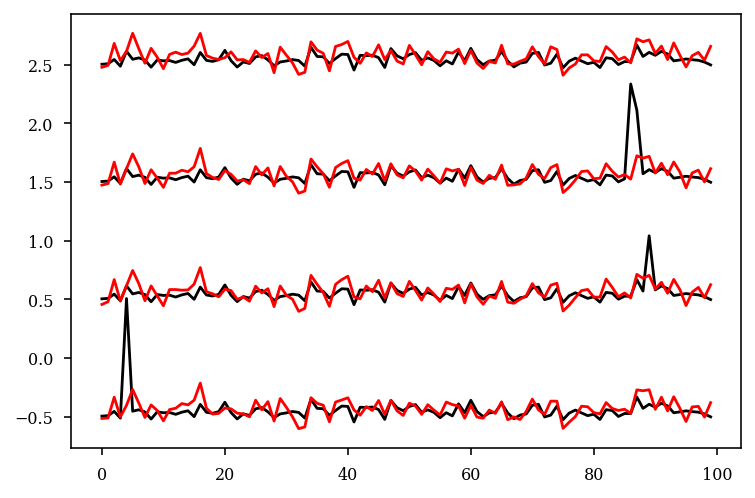

In [145]:
y_pred = regressor.predict(X_test)

for i,unit in enumerate(np.argsort(mse)[:4]):
    plt.plot(y_test[0:100,unit]+i,color='k')

    plt.plot(y_pred[0:100,unit]+i,color='r')

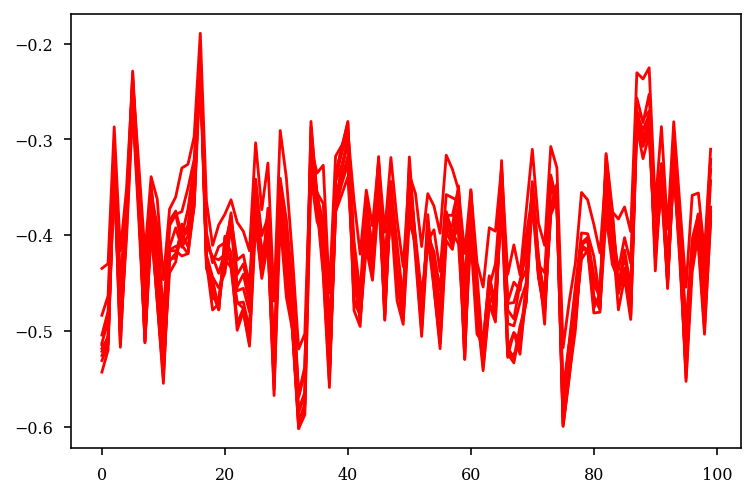

In [146]:
# sns.heatmap(y_pred.T)

for i,unit in enumerate(np.argsort(mse)[:10]):

    plt.plot(y_pred[0:100,unit],color='r')

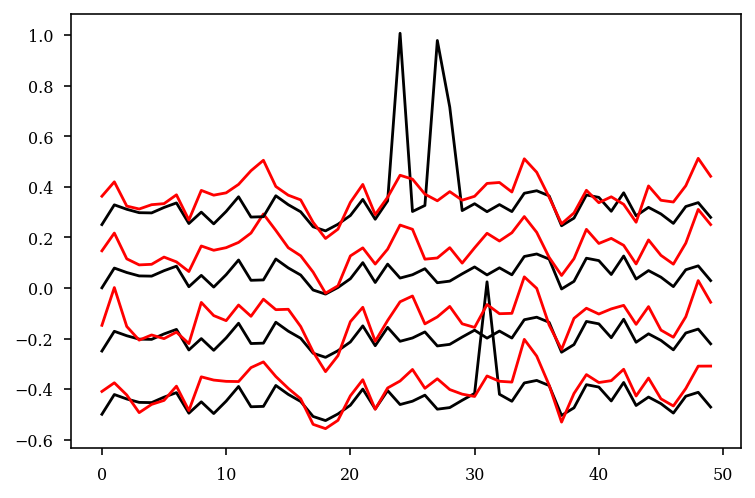

In [34]:
from sklearn.cross_decomposition import CCA, PLSCanonical, PLSRegression

# mdl = CCA().fit(X_train, y_train)
regressor.reg = 0.0001
regressor.rank = 10

regressor.fit(X_train, y_train)


y_pred = regressor.predict(X_test)

mse = mean_squared_error(
    y_test, regressor.predict(X_test), multioutput="raw_values"
)
for i,unit in enumerate(np.argsort(mse)[:4]):
    plt.plot(y_test[450:500,unit]+i*.25,color='k')

    plt.plot(y_pred[450:500,unit]+i*.25,color='r')

In [75]:
np.argsort(mse)

array([ 8, 44, 45, 81, 10, 11, 73, 49,  6, 50, 48,  5, 70, 42,  2, 29, 75,
       52, 57, 63, 54, 27, 31, 61, 18,  1, 32, 40, 20, 77, 72, 60, 68, 59,
       19, 22, 39, 25, 74, 43, 85, 86, 24, 23, 82, 83, 84, 78, 33, 34,  3,
       69, 12, 30, 67, 66, 80, 58,  9, 35,  4, 21, 56, 65, 47, 26, 37, 79,
       64, 71, 62, 41, 46, 76, 13,  7, 51, 28, 16, 14, 15, 36, 17,  0, 38,
       53, 55], dtype=int64)

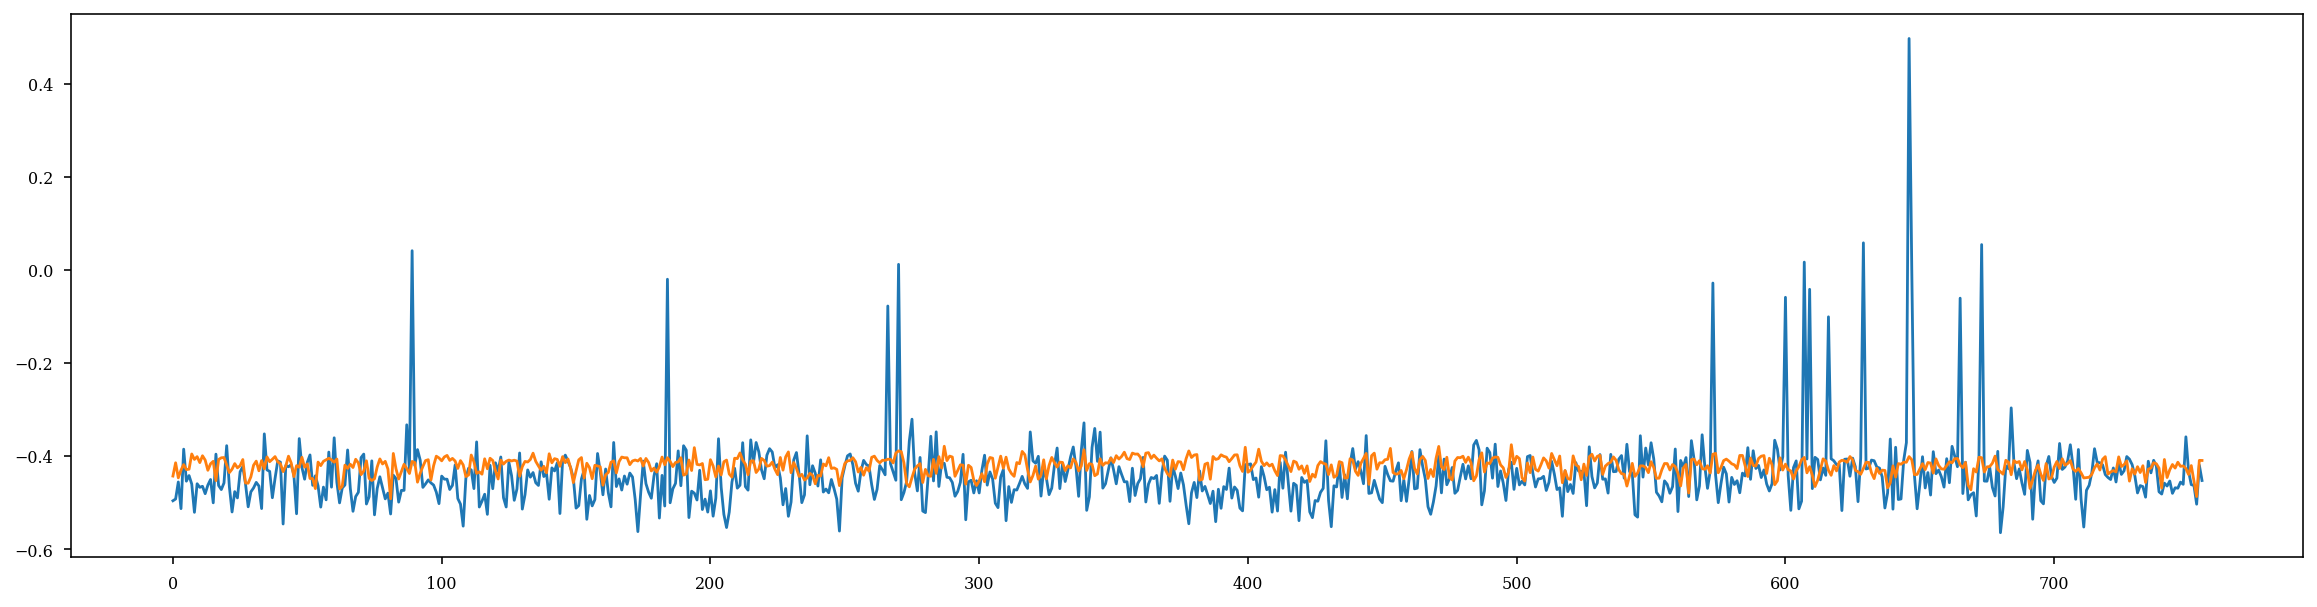

In [84]:
plt.figure(figsize=(20,5))
plt.plot(y_test[:,8])
plt.plot(y_pred[:,8])


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
# temp_df = pd.DataFrame()
fig = go.Figure()

fig.add_trace(px.line(y_test[:,8]))

# fig = px.line(y_test[:,8])
# fig = px.line(y_pred[:,8])
fig.show()

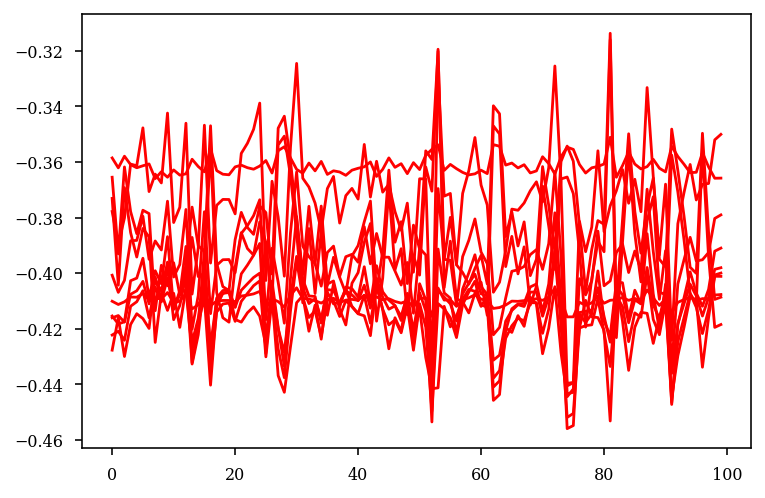

In [49]:
for i,unit in enumerate(np.argsort(mse)[:10]):

    plt.plot(y_pred[0:100,unit],color='r')

In [90]:
test_df = pd.DataFrame(y_test)
# test_df[:] = y_test

In [91]:
import scipy.cluster.hierarchy as spc


test_df = pd.DataFrame(y_test)

corr = test_df.corr().values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

In [109]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='coolwarm', vmin=-.25, vmax=.25)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-.25, 0, .25], aspect=40, shrink=.8)

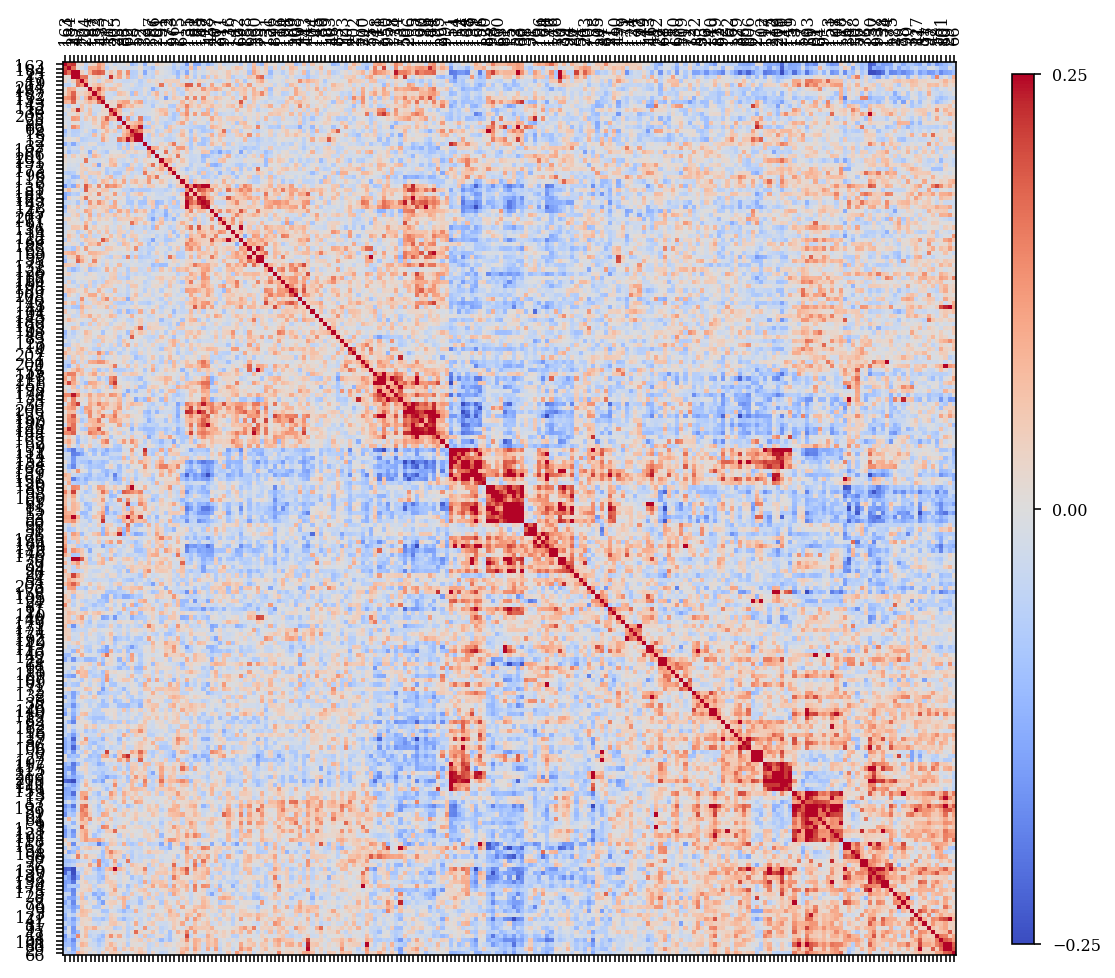

In [147]:
# import scipy
import scipy.cluster.hierarchy as sch

test_df = pd.DataFrame(y_test)

X = test_df.corr().values
d = sch.distance.pdist(X)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [test_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
test_df = test_df.reindex(columns, axis=1)

plot_corr(test_df, size=10)

In [ ]:
from scipy import stats
stats.zscore(a)

<Figure size 576x360 with 0 Axes>

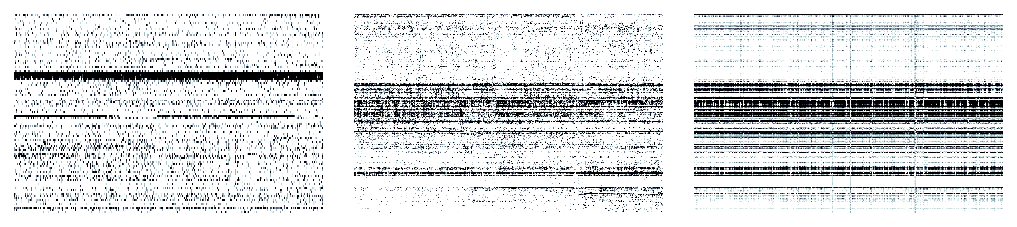

In [198]:
from scipy.ndimage import gaussian_filter
plt.figure(figsize=(8,5))

fig, axs = plt.subplots(1,3,figsize=functions.set_size("thesis", fraction=1.5, subplots=(1, 3)))
fig.subplots_adjust(hspace=0.1, wspace=.1)
axs = axs.ravel()


sns.heatmap(X_test.T,vmax=1,vmin=0,cmap='bone_r',ax=axs[0],cbar=False,rasterized=True)


# sns.heatmap(gaussian_filter(test_df.values, sigma=.5).T,vmax=1,vmin=0,cmap='bone_r')
# sns.heatmap(stats.zscore(test_df,axis=1).T,vmax=3,vmin=0,cmap='bone_r')
sns.heatmap(test_df.T,vmax=1,vmin=0,cmap='bone_r',ax=axs[1],cbar=False,rasterized=True)

# plt.show()

# plt.figure(figsize=(8,5))

y_pred = regressor.predict(X_test)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.reindex(columns, axis=1)

# y_pred_df = gaussian_filter(y_pred_df.values, sigma=.5)
# sns.heatmap(stats.zscore(y_pred_df,axis=1).T,vmax=1,vmin=0,cmap='bone_r')
sns.heatmap(y_pred_df.T,vmax=.25,vmin=-0.15,cmap='bone_r',ax=axs[2],cbar=False,rasterized=True)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
plt.savefig(
    os.path.join(fig_save_path, "rrrr_heatmap_example.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [200]:
y_pred_df.shape, X_test.shape

((756, 213), (756, 100))

In [82]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(y_test.T)

kmeans.labels_
# X = y_test.copy()

for l in kmeans.labels_:
    # X[:,0:sum(kmeans.labels_==l)] = y_test[:,kmeans.labels_==l]
# sns.heatmap(y_test[:,kmeans.labels_==1].T)

In [78]:
kmeans.labels_

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 2, 2, 2, 8, 3, 8, 8, 8,
       0, 8, 2, 8, 8, 5, 8, 8, 4, 8, 1, 8, 1, 8, 8, 8, 8, 8, 8, 2, 2, 8,
       8, 8, 2, 6, 8, 8, 8, 8, 2, 8, 8, 8, 8, 7, 8, 2, 0, 8])

<AxesSubplot:>

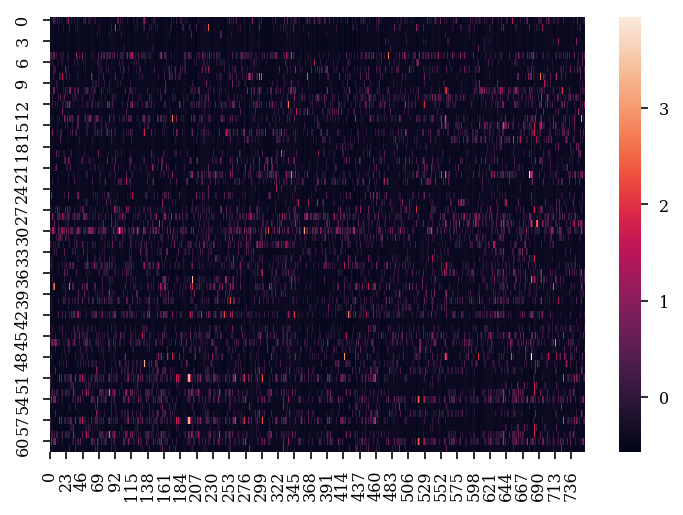

In [83]:
sns.heatmap(X.T)


In [ ]:
# # from rastermap import Rastermap
# import sys
# # path to your local download of rastermap
# sys.path.append(r'D:\github\rastermap\rastermap')
# from mapping import Rastermap

# model = Rastermap()


# model.fit(y_test)

# embedding = model.fit_transform(y_test)

In [84]:
import urllib
# download 2-photon data (if not already downloaded)
if not os.path.isfile('data/mesoscope_activity.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    response = urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/mesoscope_activity.npy');
    f=open('data/mesoscope_activity.npy','wb')
    f.write(response.read())
    f.close()

In [86]:
from scipy.stats import zscore
# load downloaded data
dat = np.load('data/mesoscope_activity.npy', allow_pickle=True)
dat = dat.item()
sp  = dat['spks']
sp  = zscore(sp, axis=1)
xyloc = dat['xyloc']

In [88]:
# rastermap algorithm
import sys
sys.path.append(r'D:\github\rastermap\rastermap')
import mapping, imp
imp.reload(mapping)

model = mapping.Rastermap(n_components=1).fit(sp)

nmin 200
0.061717987060546875
3.0000829696655273
3.049952745437622
3.061918020248413
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance


LoweringError: Failed in nopython mode pipeline (step: native lowering)
[1mFailed in nopython mode pipeline (step: native lowering)
[1m[1msuper(type, obj): obj must be an instance or subtype of type
[1m
File "..\..\..\rastermap\rastermap\mapping.py", line 1:[0m
[1m[1mfrom scipy.spatial import cKDTree
[0m[1m^[0m[0m
[0m
[0m[1mDuring: lowering "$8call_function.3 = call $2load_global.0($const4.1, cv_1, func=$2load_global.0, args=[Var($const4.1, mapping.py:1), Var(cv_1, mapping.py:1)], kws=(), vararg=None, target=None)" at D:\github\rastermap\rastermap\mapping.py (1)[0m
[0m[1mDuring: lowering "cmap = arrayexpr(expr=(<built-in function truediv>, [(<built-in function pow>, [(<ufunc 'maximum'>, [const(float, 0.0), Var(cv, mapping.py:482)]), const(int, 2)]), Var(vnorm, mapping.py:482)]), ty=array(float64, 2d, C))" at D:\github\rastermap\rastermap\mapping.py (482)[0m